In [2]:

import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [5]:
EXCHANGE_NAME = "kraken"   # change here only

exchange = getattr(ccxt, EXCHANGE_NAME)({
    "enableRateLimit": True
})

exchange.load_markets()
print(f"Connected to {EXCHANGE_NAME}")


Connected to kraken


In [16]:
symbol = "BTC/USD"   # Kraken format
timeframe = "1m"
limit = 300


ohlcv = exchange.fetch_ohlcv(
    symbol=symbol,
    timeframe=timeframe,
    limit=limit
)

df = pd.DataFrame(
    ohlcv,
    columns=["timestamp", "open", "high", "low", "close", "volume"]
)

df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
df.tail()



,timestamp,open,high,low,close,volume
295,2025-12-21 21:51:00,88127.2,88127.2,88093.5,88108.7,0.149446
296,2025-12-21 21:52:00,88108.7,88108.8,88101.4,88101.4,0.064245
297,2025-12-21 21:53:00,88101.5,88101.5,88095.2,88101.5,0.078358
298,2025-12-21 21:54:00,88101.4,88108.8,88101.4,88108.8,0.111697
299,2025-12-21 21:55:00,88118.9,88118.9,88118.9,88118.9,0.060281


In [17]:
window = 20

df["return"] = df["close"].pct_change()
df["rolling_mean"] = df["close"].rolling(window).mean()
df["rolling_std"] = df["close"].rolling(window).std()

df.tail()


,timestamp,open,high,low,close,volume,return,rolling_mean,rolling_std
295,2025-12-21 21:51:00,88127.2,88127.2,88093.5,88108.7,0.149446,-0.000146,88237.565,80.744915
296,2025-12-21 21:52:00,88108.7,88108.8,88101.4,88101.4,0.064245,-0.000083,88225.940,82.854580
297,2025-12-21 21:53:00,88101.5,88101.5,88095.2,88101.5,0.078358,0.000001,88214.320,83.212541
298,2025-12-21 21:54:00,88101.4,88108.8,88101.4,88108.8,0.111697,0.000083,88202.815,80.957821
299,2025-12-21 21:55:00,88118.9,88118.9,88118.9,88118.9,0.060281,0.000115,88191.815,76.306793


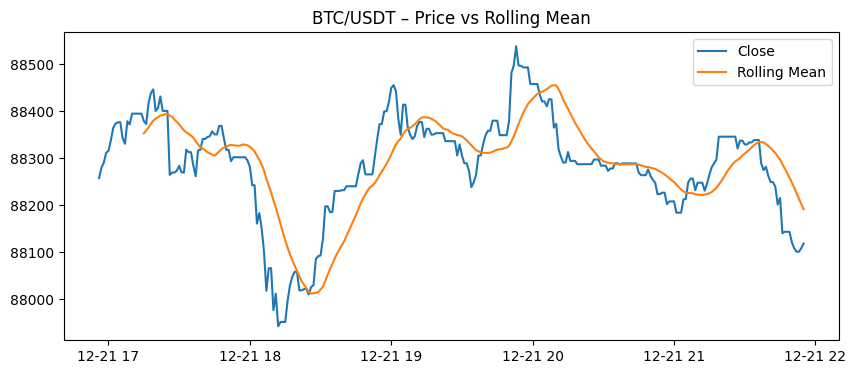

In [18]:
plt.figure(figsize=(10,4))
plt.plot(df["timestamp"], df["close"], label="Close")
plt.plot(df["timestamp"], df["rolling_mean"], label="Rolling Mean")
plt.legend()
plt.title("BTC/USDT – Price vs Rolling Mean")
plt.show()


In [19]:
def generate_signal(row):
    if row["close"] > row["rolling_mean"]:
        return 1   # BUY
    elif row["close"] < row["rolling_mean"]:
        return -1  # SELL
    return 0

df["signal"] = df.apply(generate_signal, axis=1)
df.tail()


,timestamp,open,high,low,close,volume,return,rolling_mean,rolling_std,signal
295,2025-12-21 21:51:00,88127.2,88127.2,88093.5,88108.7,0.149446,-0.000146,88237.565,80.744915,-1
296,2025-12-21 21:52:00,88108.7,88108.8,88101.4,88101.4,0.064245,-0.000083,88225.940,82.854580,-1
297,2025-12-21 21:53:00,88101.5,88101.5,88095.2,88101.5,0.078358,0.000001,88214.320,83.212541,-1
298,2025-12-21 21:54:00,88101.4,88108.8,88101.4,88108.8,0.111697,0.000083,88202.815,80.957821,-1
299,2025-12-21 21:55:00,88118.9,88118.9,88118.9,88118.9,0.060281,0.000115,88191.815,76.306793,-1


In [24]:
initial_cash = 10_000
risk_per_trade = 0.01
max_position = 0.005

stop_loss_pct = 0.005   # 0.5% below entry (example)

def position_size(cash, entry_price, stop_loss_pct=0.005):
    risk_amount = cash * risk_per_trade
    stop_loss_price = entry_price * (1 - stop_loss_pct)
    stop_distance = entry_price - stop_loss_price   # absolute dollar loss per unit
    
    if stop_distance <= 0:
        return 0
    
    size = risk_amount / stop_distance
    return size



## Paper execution simulation

In [25]:
cash = initial_cash
position = 0.0
trades = []

for _, row in df.iterrows():
    if np.isnan(row["rolling_mean"]):
        continue

    signal = row["signal"]
    price = row["close"]

    size = position_size(cash, price)

    # enforce max position
    if abs(position + size) > max_position:
        size = max_position - position

    if signal == 1 and size > 0:
        executed_price = price + 0.05
        cost = executed_price * size
        fee = cost * 0.001

        cash -= (cost + fee)
        position += size
        trades.append(("BUY", executed_price, size))

    elif signal == -1 and position > 0:
        executed_price = price - 0.05
        revenue = executed_price * position
        fee = revenue * 0.001

        cash += (revenue - fee)
        trades.append(("SELL", executed_price, position))
        position = 0


In [26]:
final_value = cash + position * df.iloc[-1]["close"]

print(f"Final portfolio value: {final_value:.2f}")
print(f"Total trades executed: {len(trades)}")


Final portfolio value: 9995.36
Total trades executed: 14


In [27]:
trades

[('BUY', 88379.35, 0.005),
 ('SELL', 88264.65, 0.005),
 ('BUY', 88341.35, 0.005),
 ('SELL', 88318.05, 0.005),
 ('BUY', 88026.55, 0.005),
 ('SELL', 88350.34999999999, 0.005),
 ('BUY', 88330.55, 0.005),
 ('SELL', 88435.65, 0.005),
 ('BUY', 88289.55, 0.005),
 ('SELL', 88286.55, 0.005),
 ('BUY', 88289.25, 0.005),
 ('SELL', 88269.75, 0.005),
 ('BUY', 88248.65000000001, 0.005),
 ('SELL', 88289.15, 0.005)]